Create dataframe for file and its label.

Essentials imports.

In [8]:
import pandas as pd # for data manipulation
import matplotlib.pyplot as plt # for image plotting
import os # to get the path of image
import cv2 # for image manipulation
import random as rn # random number generator
from PIL import Image # python image library for image manipulation
from skimage import feature # for image feature extraction
from sklearn.preprocessing import LabelEncoder # to encode the labels of data
import pickle # to save the model

Taking a glance at the data.

In [9]:
labels = pd.read_csv("datasets/labels.csv", index_col=0)
labels = labels.reset_index()

labels.head()


,file_name,disease_type
0,Normal-1,normal
1,Normal-2,normal
2,Normal-3,normal
3,Normal-4,normal
4,Normal-5,normal


Suffling and resetting the index.

In [10]:
labels = labels.sample(frac=1).reset_index(drop=True)
labels.head()

,file_name,disease_type
0,COVID-1174,covid
1,Normal-1368,normal
2,Normal-255,normal
3,Normal-3329,normal
4,COVID-548,covid


Create a function to display image refrence to its index and return the file_name and disease_type.

In [11]:
def show_image(index):
    """
    Displays an image from the dataset with respect to the given index and returns the subspecies|.
    """
    file_name = labels[labels.index==index].file_name.values[0]
    disease_type = labels[labels.index==index].disease_type.values[0]
    root="datasets/images/"
    img_path = os.path.join(root, file_name) + ".png"
    img = cv2.imread(img_path)
    img = cv2.resize(img, (100, 100), interpolation = cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img, cmap='gray')
    plt.show()
    return file_name, disease_type
    

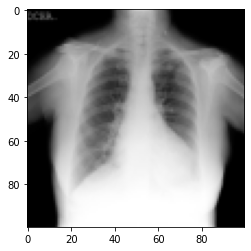

('COVID-1174', 'covid')

In [12]:
show_image(0)

Generate the hog features.

In [13]:
def hog_data_extractor(img_name):
    root="datasets/images/"
    img_path = os.path.join(root, img_name)
    img_data = cv2.imread(img_path)
    img_data = cv2.resize(img_data, (100, 100), interpolation = cv2.INTER_AREA)
    img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
    hog_data = feature.hog(img_data)/255.0
    return hog_data

In [14]:
hog_data_extractor("Normal-827.png")

array([9.86534805e-04, 1.58958544e-04, 1.42869000e-05, ...,
       0.00000000e+00, 5.47894364e-05, 4.96806678e-04])

Save file_name and subspecies to array.

In [15]:

img_name_all = labels.file_name.values
disease_types_all = labels.disease_type.values
img_name_all

array(['COVID-1174', 'Normal-1368', 'Normal-255', ..., 'COVID-392',
       'COVID-197', 'COVID-1950'], dtype=object)

Store the hog features in to X_train and X_test.

In [16]:
X_train = []
X_test = []
label_train = []
label_test = []

train_percent = 0.7
data_length = len(img_name_all)
train_index = int(data_length*train_percent)

In [17]:

for i in range(train_index):
    try:
        hog_data = hog_data_extractor(img_name_all[i]+".png")
        X_train.append(hog_data)
        label_train.append(disease_types_all[i])
    except:
        print(img_name_all[i], disease_types_all[i])
        print("Error")

In [18]:
for i in range(train_index, data_length):
    try:
        hog_data = hog_data_extractor(img_name_all[i]+".png")
        X_test.append(hog_data)
        label_test.append(disease_types_all[i])
    except:
        print(img_name_all[i], disease_types_all[i])
        print("Error")

Use label encoder to encode the disease type where **covid** is encoded as *0* and **normal** is encoded as *1*.

In [ ]:
le = LabelEncoder()
y_train = le.fit_transform(label_train)
y_test = le.fit_transform(label_test)
print(f"{label_train[0]} is encoded as {y_train[0]}")

covid is labeled as 0


Create a variable to store the label in the sequence of "covid" and "normal" respectively so they represent 0 and 1 the elements in the array.

In [20]:
disease_types = ['covid', 'normal']

Create a Linear SVM classifier and train it.

In [21]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC

In [22]:
svc = SVC(C=1000, kernel='poly', degree=4, tol=1e-5)
svc.fit(X_train, y_train)
svc_score = svc.score(X_test, y_test)
print("svc_score: ", svc_score)

svc_score:  0.9341121495327103


Score and Cross validation result of the model.

In [23]:
# filter all the warnings
import warnings
warnings.filterwarnings("ignore")

# 10-fold cross validation
kfold = KFold(n_splits=10, random_state=9, shuffle=True)
cv_results = cross_val_score(svc, X_train, y_train, cv=kfold, scoring='accuracy')
print(cv_results)

In [ ]:
print(cv_results.mean(), cv_results.std())

0.9338917835671342 0.014925404400393113


Classification Reoport:

In [ ]:
print(classification_report(y_test, svc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1087
           1       0.94      0.92      0.93      1053

    accuracy                           0.93      2140
   macro avg       0.93      0.93      0.93      2140
weighted avg       0.93      0.93      0.93      2140



In [ ]:
c_matrix = confusion_matrix(y_test, svc.predict(X_test))
print(c_matrix)

[[1025   62]
 [  89  964]]


Create a function to predict the disease.

In [ ]:
def disease_predict(img_name):
    root="datasets/images/"
    img_path = os.path.join(root, img_name) + ".png"
    ip_image = Image.open(img_path)
    prd_image_data = hog_data_extractor(img_name+".png")
    disease_type_predict = svc.predict(prd_image_data.reshape(1, -1))
    
    title =f"Original: {labels.disease_type[labels.file_name == img_name].values[0]} \n Predicted: {disease_types[disease_type_predict[0]]}"
    plt.figure()
    plt.imshow(ip_image, cmap='gray')
    plt.title(title)

Randomly take a sample of the data and predict the disease.

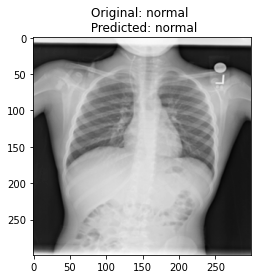

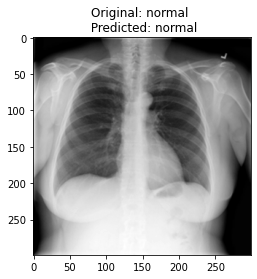

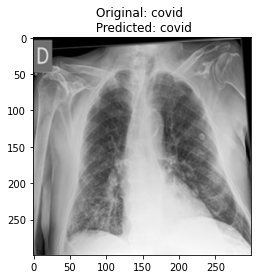

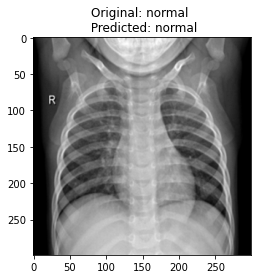

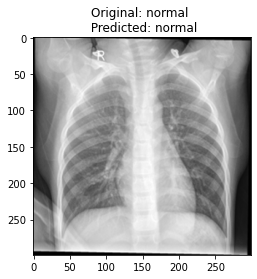

In [ ]:
ip_img_files = labels.file_name.values.tolist()[train_index:] # taking only the test images
rnd = rn.randint(0, len(ip_img_files)-1)
predicted_diseases = [disease_predict(file_name) for file_name in ip_img_files[rnd:rnd+5]] # predicted_diseases doesnt contains anything, used only to stop veberse

Saving model

In [ ]:
pickle.dump(svc, open('./models/svc.pkl','wb'))

In [ ]:
dd``